In [11]:
# Importing essential libraries for data handling, visualization, and deep learning tasks.
# These libraries include TensorFlow for deep learning, NumPy for numerical operations,
# Pandas for data manipulation, and Matplotlib/Seaborn for visualization.

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [12]:
# Setting hyperparameters for image processing and data augmentation.
# The batch size determines the number of samples processed before the model is updated,
# and the target image size is set to 224x224 pixels, consistent with VGG16 requirements.

folder_path = r'C:\Users\Can\Downloads\raw-img'


# Initializing ImageDataGenerator for preprocessing and augmenting training and validation datasets.
# The validation split is set to 15% to ensure a portion of data is held out for evaluation.

batch_size = 16
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,  # Normalize pixel values to [0,1]
                             rotation_range=20,  # Randomly rotate images in the range (0-20 degrees)
                             width_shift_range=0.2,  # Randomly shift images horizontally
                             height_shift_range=0.2,  # Randomly shift images vertically
                             shear_range=0.2,  # Randomly shear images
                             zoom_range=0.2,  # Randomly zoom into images
                             horizontal_flip=True,  # Randomly flip images horizontally
                             fill_mode='nearest',  # Fill pixels with nearest pixel values
                             validation_split=0.15)  # Set aside 15% for validation

# Loading training data from the specified directory with defined augmentations.
# Class mode is set to 'categorical' for multi-class classification.

train_generator = datagen.flow_from_directory(folder_path,
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical',
                                              subset='training')

# Loading validation data from the specified directory with similar augmentations.
# Shuffling is disabled to maintain order for validation evaluation.

validation_generator = datagen.flow_from_directory(folder_path,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  subset='validation')


Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [13]:
# Setting up the VGG16 model as a base for transfer learning.
# The 'include_top' parameter is set to False to remove the top fully connected layers,
# allowing us to add our custom classifier. Pre-trained weights from ImageNet are utilized.


base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

# Creating the model by adding global average pooling and dense layers on top of VGG16.
# A dense layer with 512 units and ReLU activation is added, followed by an output layer
# with softmax activation for multi-class predictions (10 classes).

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compiling the model with categorical crossentropy loss and Adam optimizer.
# The learning rate is set to 0.0001 for fine-tuning.

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Setting up model training callbacks to manage training process and model saving.
# ModelCheckpoint saves the model with the best validation loss, while EarlyStopping halts training
# if no improvement is observed for 5 epochs, restoring the best weights.
# ReduceLROnPlateau reduces the learning rate when validation loss plateaus, aiding convergence.


model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [16]:
# Fitting the model to the training data while validating against the validation set.
# Training runs for a specified number of epochs, and callbacks are included to monitor performance.

history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])



Epoch 1/15
1392/1392 [==============================] - ETA: 0s - loss: 1.2948 - accuracy: 0.5465
Epoch 1: val_loss improved from inf to 0.78075, saving model to model.keras
1392/1392 [==============================] - 731s 521ms/step - loss: 1.2948 - accuracy: 0.5465 - val_loss: 0.7807 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 2/15
1392/1392 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.7936
Epoch 2: val_loss improved from 0.78075 to 0.47651, saving model to model.keras
1392/1392 [==============================] - 704s 506ms/step - loss: 0.6275 - accuracy: 0.7936 - val_loss: 0.4765 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 3/15
1392/1392 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8578
Epoch 3: val_loss did not improve from 0.47651
1392/1392 [==============================] - 711s 511ms/step - loss: 0.4412 - accuracy: 0.8578 - val_loss: 0.5297 - val_accuracy: 0.8320 - lr: 1.0000e-04
Epoch 4/15
1392/1392 [===================

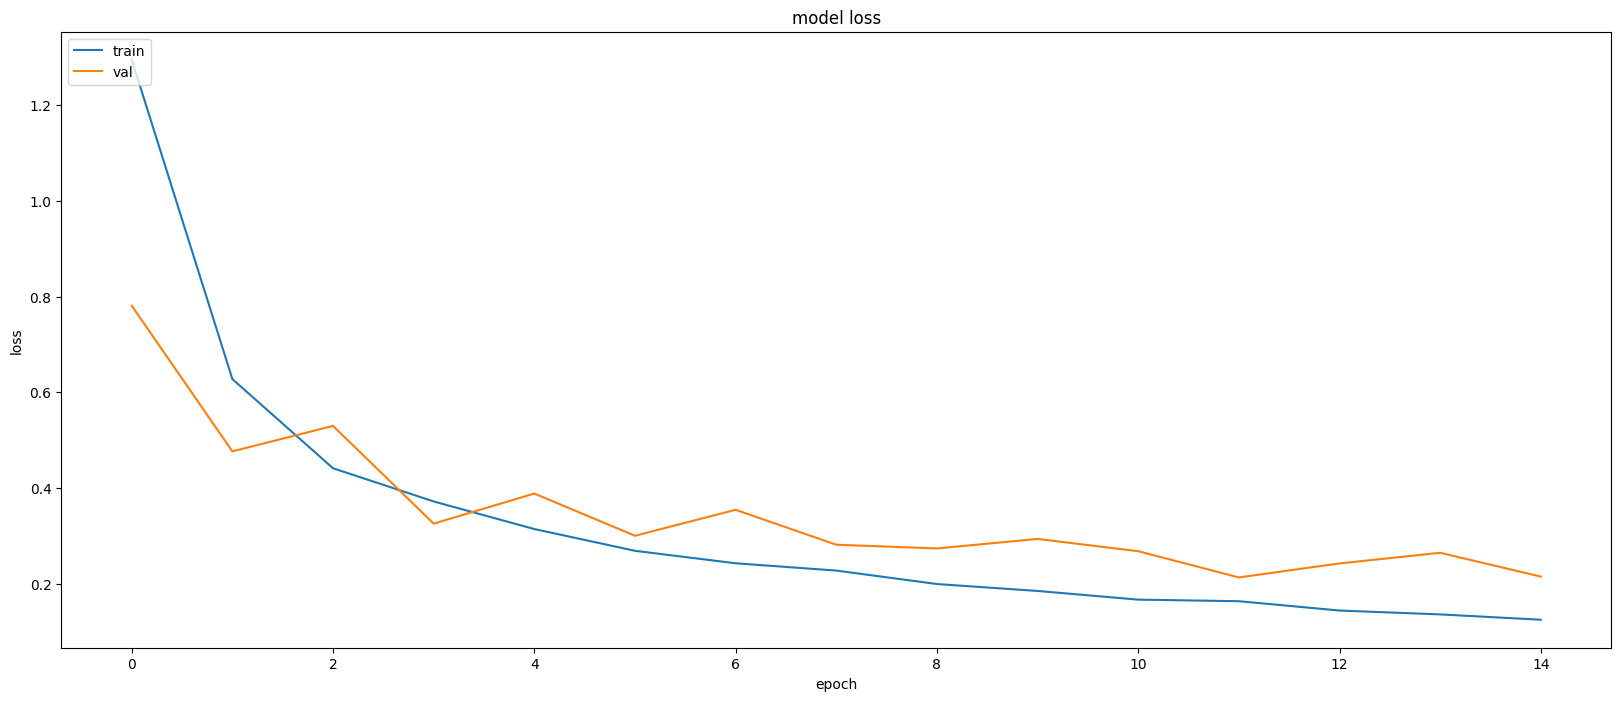

In [19]:
import matplotlib.pyplot as plt

# Visualizing the training and validation loss over epochs to assess model performance.
# This plot helps identify overfitting if the validation loss diverges from training loss.

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

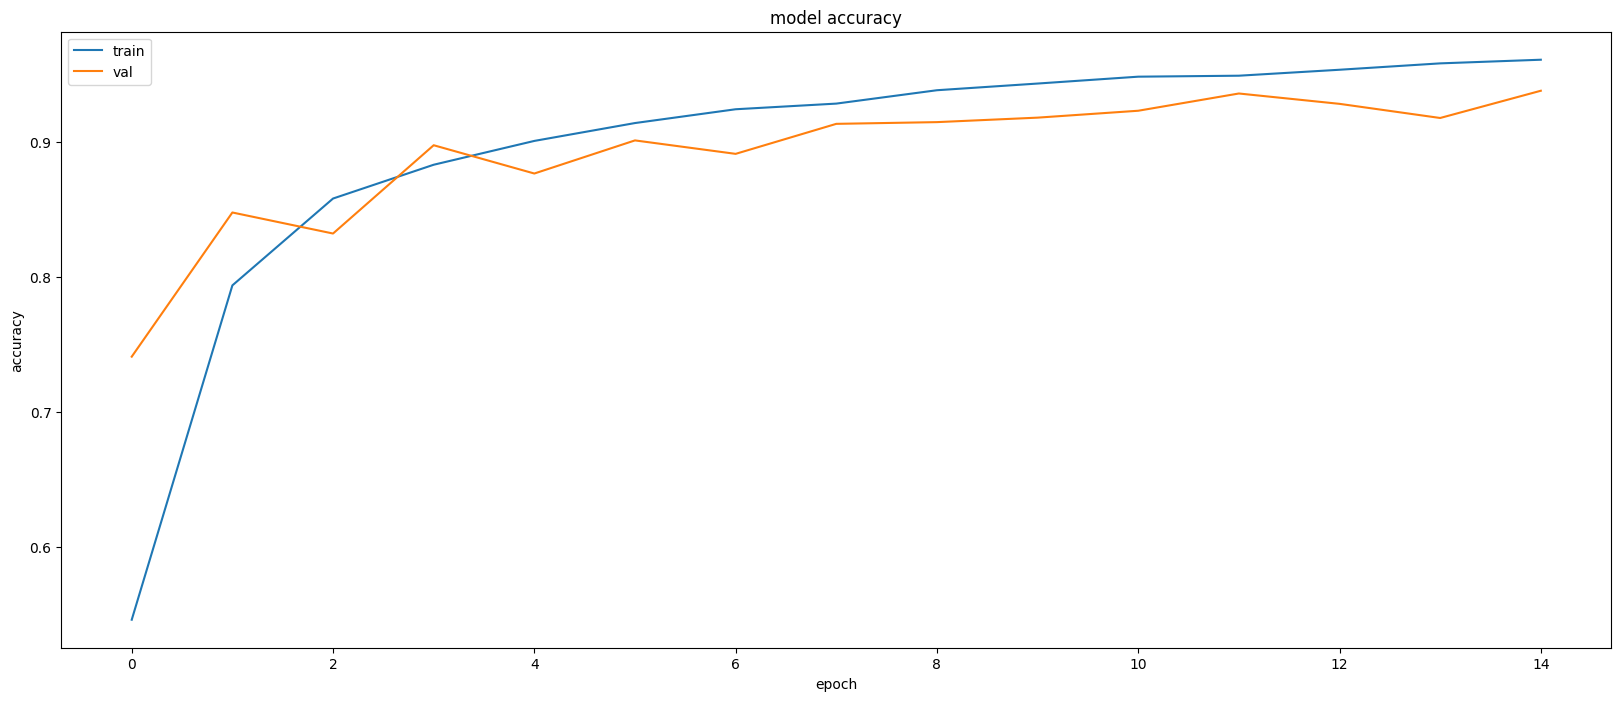

In [20]:
# Visualizing the training and validation accuracy over epochs.
# This helps in understanding how well the model is performing on training and validation datasets.

plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# Retrieving the true class labels for the validation set and making predictions using the trained model.
# Predictions are converted to class labels for evaluation.

y_val = validation_generator.classes # True labels
y_pred = model.predict(validation_generator) # Model predictions
y_pred = np.argmax(y_pred,axis=1) # Convert probabilities to class labels

246/246 [==============================] - 39s 158ms/step


In [25]:
import numpy as np

# Initialize dictionaries to hold TP, FP, FN counts for each class
classes = validation_generator.class_indices.keys()
num_classes = len(classes)

# Initialize metrics
tp = {cls: 0 for cls in range(num_classes)}
fp = {cls: 0 for cls in range(num_classes)}
fn = {cls: 0 for cls in range(num_classes)}

# Compute TP, FP, FN for each class
for true_label, pred_label in zip(y_val, y_pred):
    if true_label == pred_label:
        tp[true_label] += 1
    else:
        fp[pred_label] += 1
        fn[true_label] += 1

# Calculate precision, recall, and F1-score
precision = {}
recall = {}
f1_score = {}
support = {}

for cls in range(num_classes):
    support[cls] = tp[cls] + fn[cls]  # Total true instances for each class
    if tp[cls] + fp[cls] > 0:
        precision[cls] = tp[cls] / (tp[cls] + fp[cls])
    else:
        precision[cls] = 0.0
    if tp[cls] + fn[cls] > 0:
        recall[cls] = tp[cls] / (tp[cls] + fn[cls])
    else:
        recall[cls] = 0.0
    if precision[cls] + recall[cls] > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0.0

# Print the report
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1 Score':<10}{'Support'}")
for cls, cls_name in enumerate(classes):
    print(f"{cls_name:<15}{precision[cls]:<10.2f}{recall[cls]:<10.2f}{f1_score[cls]:<10.2f}{support[cls]}")


Class          Precision Recall    F1 Score  Support
cane           0.88      0.96      0.92      729
cavallo        0.93      0.92      0.93      393
elefante       0.91      0.95      0.93      216
farfalla       0.96      0.93      0.95      316
gallina        0.98      0.94      0.96      464
gatto          0.95      0.93      0.94      250
mucca          0.93      0.91      0.92      279
pecora         0.91      0.82      0.86      273
ragno          0.96      0.98      0.97      723
scoiattolo     0.96      0.89      0.92      279


In [26]:
# Creating a mapping of class indices to class labels for better readability in results.
# This facilitates interpretation of model predictions against actual labels.

class_indices = validation_generator.class_indices # Retrieve class indices
indices = {v:k for k,v in class_indices.items()} # Map indices to class labels

In [27]:
# Retrieving filenames from the validation generator for visualization and analysis of results.

filenames = validation_generator.filenames

# Constructing a DataFrame to summarize the filenames, actual labels, and predicted labels.
# This helps in comparing model predictions with true labels and identifying misclassifications.

val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x]) # Map actual labels
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x]) # Map predicted labels
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True # Identify correct predictions
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False # Identify incorrect predictions
val_df.head(10)

# Shuffling the DataFrame containing validation results to ensure a varied sample is displayed.
# This is helpful for visual inspection of correctly and incorrectly classified images.

val_df = val_df.sample(frac=1).reset_index(drop=True)



In [44]:
# Function to read and preprocess images for visualization.
# Images are loaded, resized, and normalized before being returned for display.


def readImage(path):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size)) # Load and resize image
    img = img_to_array(img) # Convert image to array format
    img = img / 255. # Normalize pixel values
    return img

# Function to display images along with their actual and predicted labels.
# This helps visualize model performance on individual samples.

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n) # Create a grid for displaying images
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        # Updated path
        image = readImage(rf"C:\Users\Can\Downloads\raw-img\{temp_df.filename[i]}") # Read image
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')


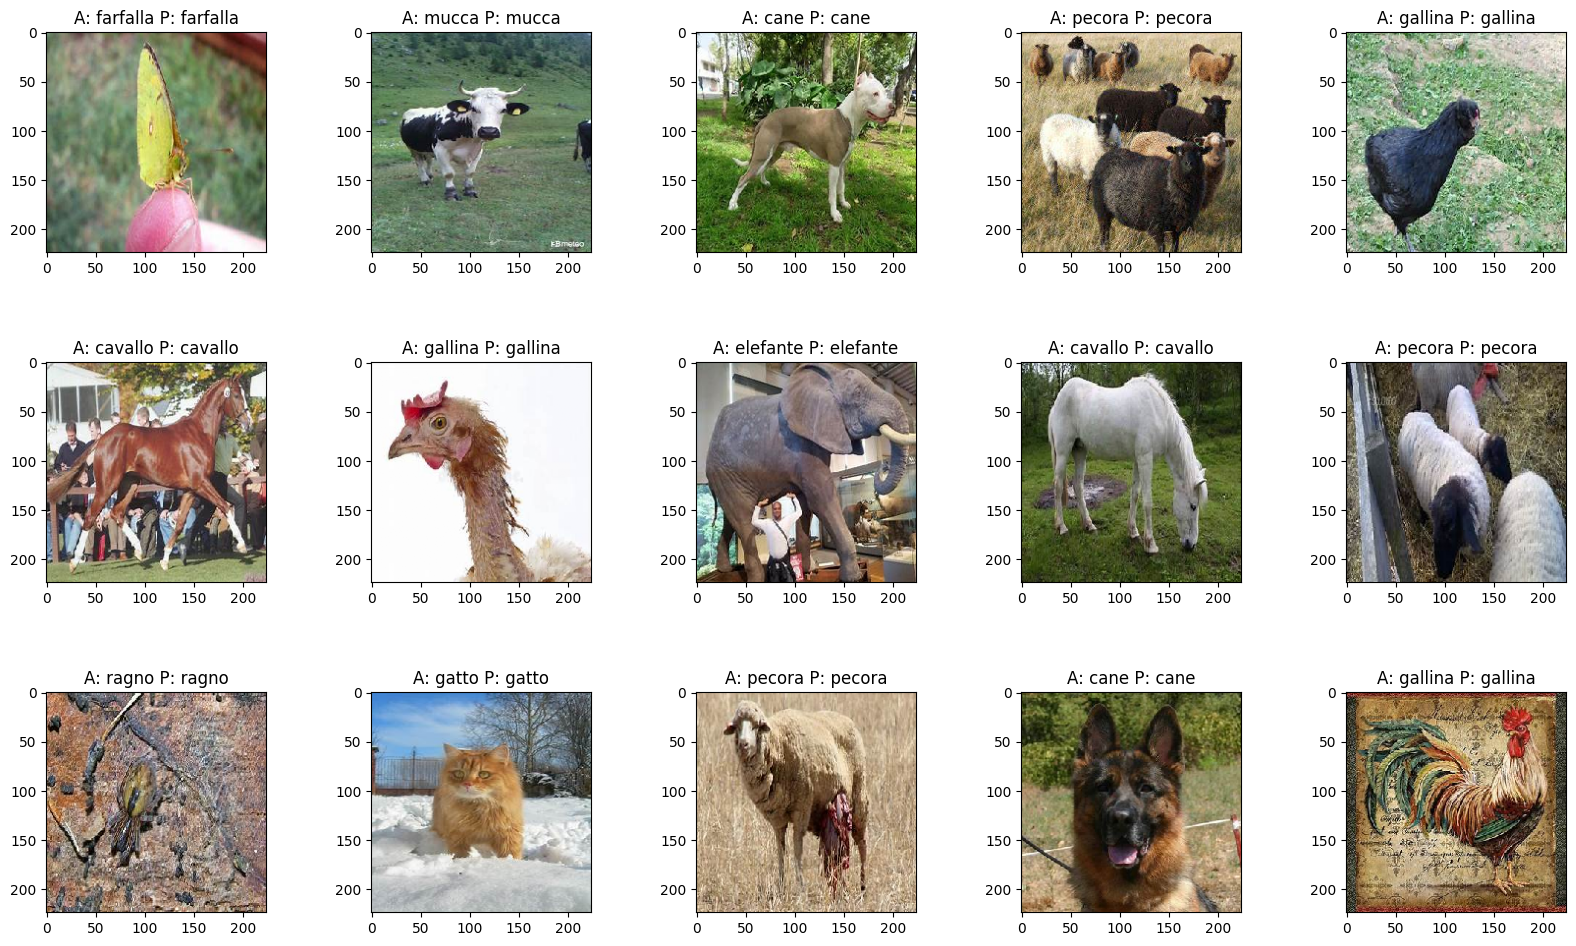

In [47]:
# Displaying a selection of correctly classified images.
# This allows for a quick verification of model success.

display_images(val_df[val_df['Same'] == True])


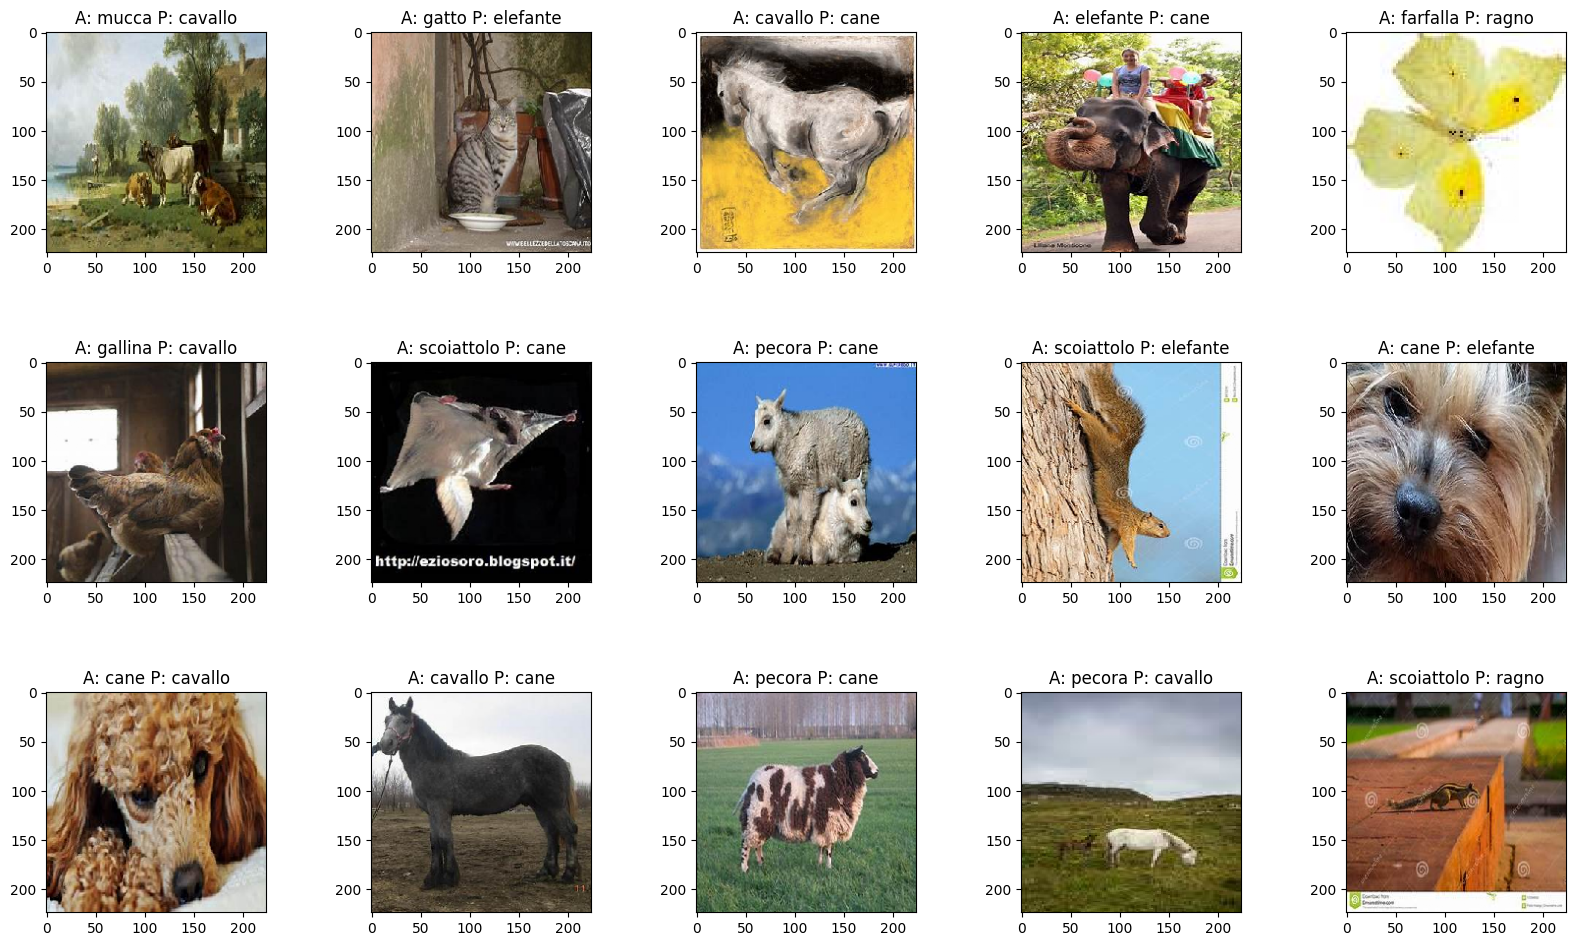

In [45]:
# Displaying a selection of incorrectly classified images.
# This helps identify areas where the model may need improvement or additional training.

display_images(val_df[val_df['Same']!=True])



In [36]:
# Defining a function to generate Grad-CAM heatmaps based on model predictions.
# This uses the gradients of the predicted class with respect to the model's output.
# Grad-CAM helps in understanding the regions of the input image that influenced the model's predictions.

def make_gradcam_heatmap(img_array, model, pred_index=None):
    """
    Generate a Grad-CAM heatmap for a given image array using the specified model.
    Args:
        img_array: The input image array (preprocessed).
        model: The Keras model used for predictions.
        pred_index: The index of the predicted class. If None, the top prediction is used.
    Returns:
        heatmap: The heatmap representing the model's focus on the image.
        preds: The model's predictions for the input image.
    """
    # Create a model that outputs the last conv layer's output and predictions
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    # Track gradients during the forward pass
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array) 
        
        # Use the predicted class if pred_index is not provided
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  
        class_channel = preds[:, pred_index]

    # Calculate gradients of the class output with respect to the conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average the gradients

    last_conv_layer_output = last_conv_layer_output[0]  # Remove unnecessary dimensions
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # Generate heatmap
    heatmap = tf.squeeze(heatmap)  # Remove unnecessary dimensions

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize heatmap
    return heatmap.numpy(), preds  # Return heatmap and predictions



In [37]:
import matplotlib.cm as cm

In [48]:
def gradCAMImage(image):
    """
    Generate a Grad-CAM superimposed image for a given input image.
    
    Args:
        image: The filename of the image for which to generate the Grad-CAM visualization.
        
    Returns:
        superimposed_img: The original image with the Grad-CAM heatmap superimposed.
    """
    # Construct the path to the image
    path = rf"C:\Users\Can\Downloads\raw-img\{image}"
    
    # Read and preprocess the image
    img = readImage(path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Generate the Grad-CAM heatmap and predictions
    heatmap, preds = make_gradcam_heatmap(img, model)

    # Load the original image for visualization
    img = load_img(path)
    img = img_to_array(img)  # Convert to array

    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255

    # Create a colormap (jet) for colorizing the heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Get RGB colors from the colormap
    jet_heatmap = jet_colors[heatmap]  # Apply colormap to the heatmap

    # Convert the heatmap to an image and resize it to the original image's dimensions
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.8 + img  # Blend heatmap with the image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)  # Convert back to image

    return superimposed_img  # Return the final image


In [39]:
def gradcam_of_images(correct_class):
    """
    Generate Grad-CAM visualizations for images classified correctly or incorrectly.

    Args:
        correct_class: Boolean value indicating whether to filter for correctly (True) 
                       or incorrectly (False) classified images.

    Returns:
        grad_images: List of images with Grad-CAM heatmaps applied.
        title: List of titles corresponding to each image.
    """
    grad_images = []  # List to store the Grad-CAM images
    title = []  # List to store titles for the images
    
    # Filter the validation dataframe based on the classification correctness
    temp_df = val_df[val_df['Same'] == correct_class]
    temp_df = temp_df.reset_index(drop=True)  # Reset index for easier iteration
    
    # Loop through the first 15 images
    for i in range(15):
        image = temp_df.filename[i]  # Get the filename
        grad_image = gradCAMImage(image)  # Generate Grad-CAM image
        grad_images.append(grad_image)  # Store the Grad-CAM image
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")  # Store the title

    return grad_images, title  # Return the list of images and titles


# Generate Grad-CAM images for correctly and incorrectly classified images
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)


def display_heatmaps(classified_images, titles):
    """
    Display Grad-CAM images with their corresponding titles.

    Args:
        classified_images: List of images with Grad-CAM applied.
        titles: List of titles corresponding to each image.
    """
    plt.figure(figsize=(20, 20))  # Set the figure size
    n = 0  # Initialize counter for subplot indexing
    
    # Loop through the images to create subplots
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)  # Create a subplot
        plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots
        plt.imshow(classified_images[i])  # Display the image
        plt.title(titles[i])  # Set the title for the image
    plt.show()  # Show the complete figure


C:\Users\Can\AppData\Local\Temp\ipykernel_22888\1079372327.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


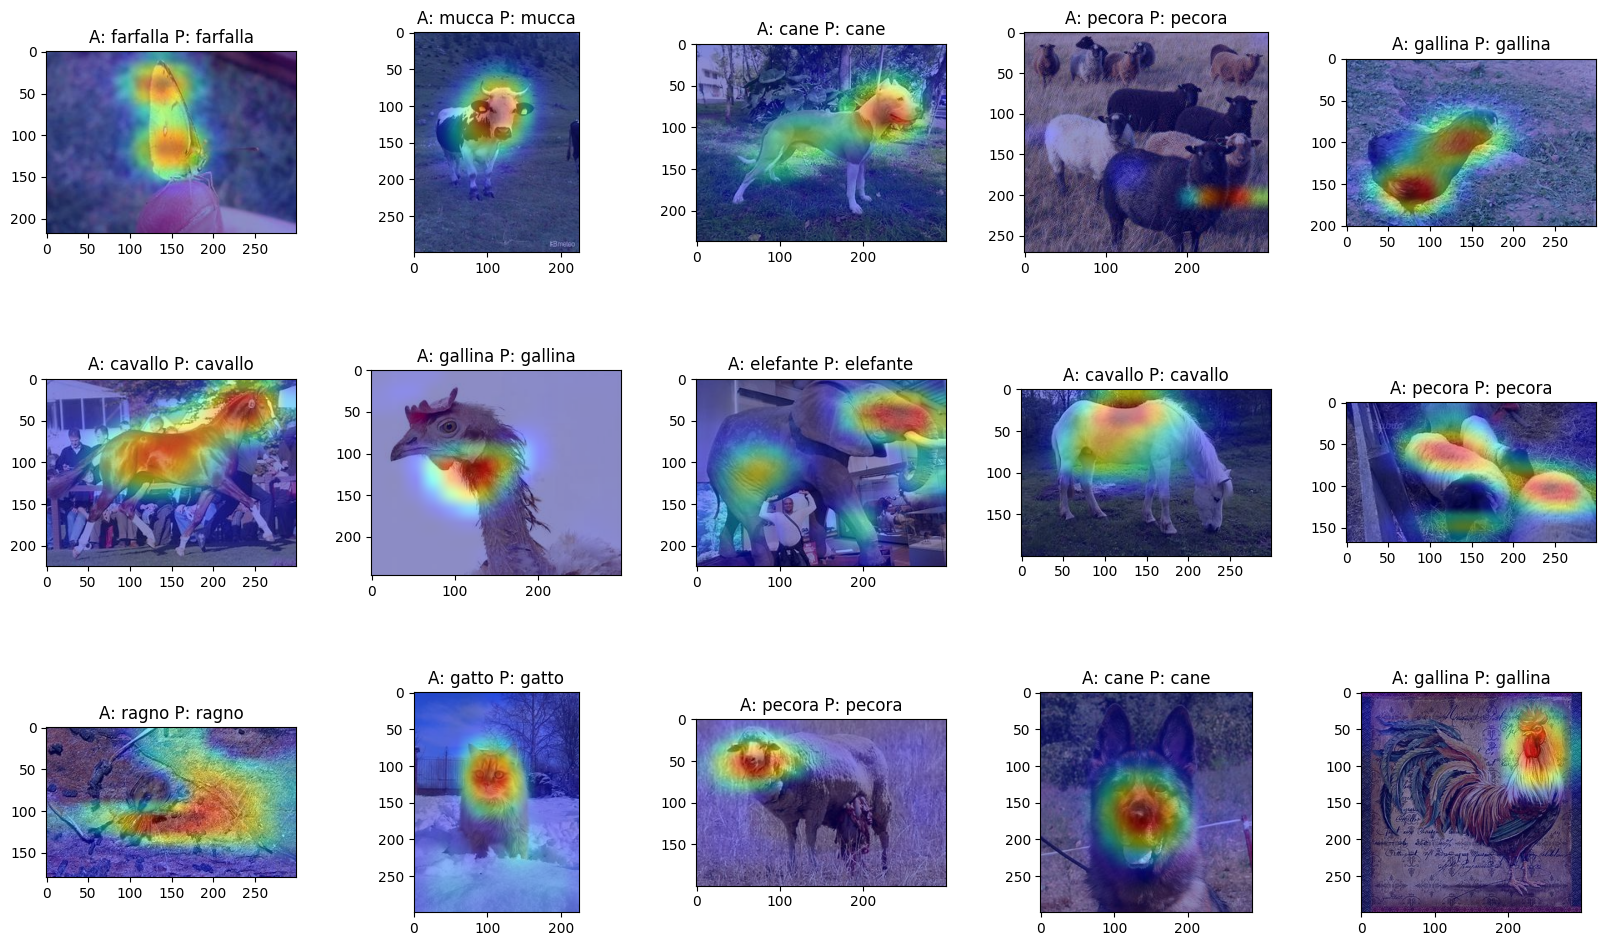

In [40]:
display_heatmaps(correctly_classified,c_titles)

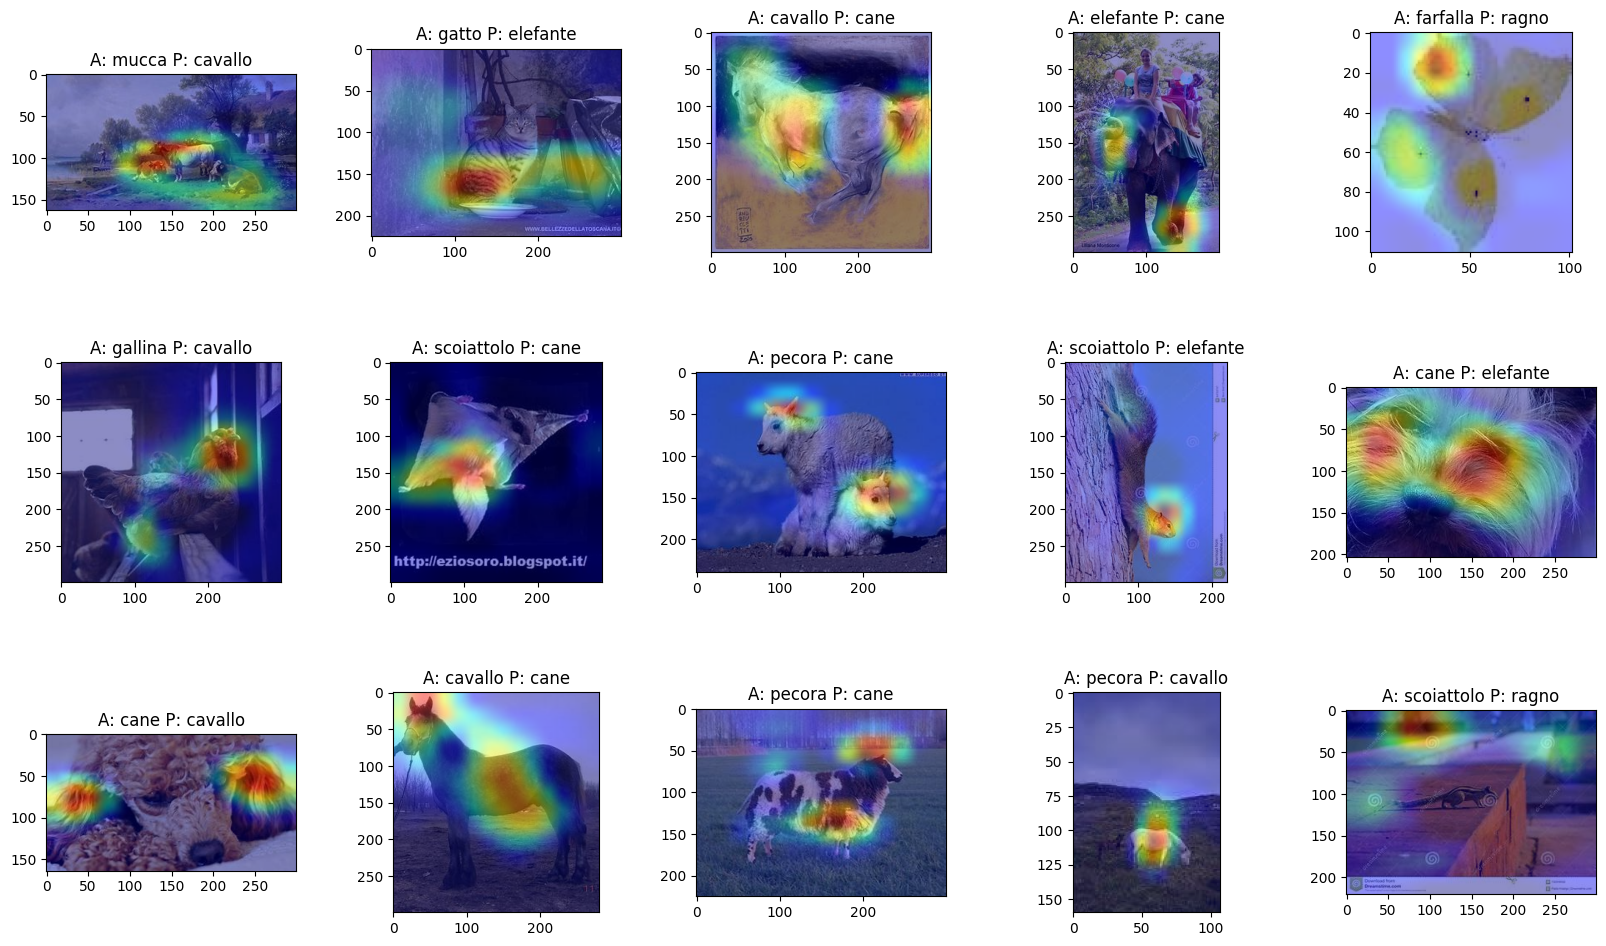

In [41]:
display_heatmaps(misclassified,m_titles)